Colonnes — signification simple

ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 sq.ft (indique des zones avec grandes parcelles).

INDUS : proportion de terrains occupés par des activités non-commerciales au détail (zones industrielles).

CHAS : variable binaire (dummy) — 1 si le secteur borde la rivière Charles, 0 sinon.

NOX : concentration d’oxydes d’azote (pollution) — mesurée en parties par 10 millions ; valeur plus élevée = plus de pollution.

RM : nombre moyen de pièces (rooms) par logement — indicateur direct de taille du logement.

AGE : part des logements occupés par leur propriétaire construits avant 1940 (pourcentage) — mesure de l’ancienneté du parc immobilier.

DIS : distance pondérée (distance “harmonisée”) aux cinq centres d’emploi de Boston — mesure d’accessibilité à l’emploi.

RAD : indice d’accessibilité aux autoroutes radiales (plus la valeur est grande, meilleure l’accessibilité routière).

TAX : taux d’imposition foncière (full-value property-tax rate) par tranche de 10 000$ — indicateur fiscal local.

PTRATIO : ratio élèves/professeur dans la ville (pupil-teacher ratio) — proxy pour la qualité des écoles.

B : transformée 1000*(Bk - 0.63)^2 où Bk est la proportion de population noire par ville ; c’est une variable démographique transformée.

LSTAT : pourcentage de la population « lower status » (statut socio-économique bas) — souvent corrélé négativement au prix des logements.

MEDV : cible — valeur médiane des logements occupés par leur propriétaire (en milliers de dollars, $1000s).

Importations

In [18]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from dotenv import load_dotenv

load_dotenv()



True

# Pipeline Data:

In [ ]:


from typing import Dict, List, Tuple, Optional

class TooManyMissingError(Exception):
    """Exception levée quand le taux de missing dépasse le seuil autorisé."""
    def __init__(self, cols_too_many: Dict[str, float], message: Optional[str] = None):
        if message is None:
            message = "Colonnes avec trop de valeurs manquantes (au-dessus du seuil) :\n"
            message += "\n".join([f" - {c}: {p:.2%}" for c, p in cols_too_many.items()])
        super().__init__(message)
        self.cols_too_many = cols_too_many

def initial_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Nettoyages de base :
    - normalise noms de colonnes (strip, lower, remplace espaces par underscore)
    - supprime les colonnes entièrement vides
    - supprime les doublons exacts de lignes
    - convertit les colonnes numériques représentées en chaînes en types numériques si possible
    - retire les index inutiles et resette index
    """
    df = df.copy()

    # Normaliser noms de colonnes
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]

    # Drop columns fully empty
    cols_all_na = [c for c in df.columns if df[c].isna().all()]
    if cols_all_na:
        df.drop(columns=cols_all_na, inplace=True)

    # Convert possible numeric-like columns to numeric
    for col in df.columns:
        if df[col].dtype == object:
            # essayer conversion en numérique (coerce errors => NaN)
            converted = pd.to_numeric(df[col].str.replace(",", "").str.strip(), errors="coerce")
            # si beaucoup de valeurs converties (par ex > 50%), remplacer dtype
            non_na_ratio = converted.notna().mean()
            if non_na_ratio >= 0.5:
                df[col] = converted

    # Drop exact duplicate rows
    df = df.drop_duplicates().reset_index(drop=True)

    return df

def compute_missing_rates(df: pd.DataFrame) -> Dict[str, float]:
    """Retourne un dict col -> taux de missing (float entre 0 et 1)."""
    
    return {col: df[col].isna().mean() for col in df.columns}

def impute_column(series: pd.Series, strategy: str = "median") -> Tuple[pd.Series, Dict]:
    """
    Impute une Series selon strategy :
    - numeric: 'median' (par défaut) ou 'mean' ou 'constant'
    - categorical (object / category): 'mode' ou 'constant'
    Retourne (series_imputed, info_dict)
    """
    info = {"dtype": str(series.dtype), "strategy": strategy, "n_missing_before": int(series.isna().sum())}
    s = series.copy()

    if pd.api.types.is_numeric_dtype(s):
        if strategy == "median":
            fill = s.median()
        elif strategy == "mean":
            fill = s.mean()
        elif strategy == "constant":
            fill = 0
        else:
            raise ValueError(f"Unknown numeric strategy: {strategy}")
        s = s.fillna(fill)
        info.update({"fill_value": float(fill), "n_missing_after": int(s.isna().sum())})
    else:
        # categorical
        if strategy == "mode":
            if s.dropna().empty:
                fill = "missing"
            else:
                fill = s.mode().iloc[0]
        elif strategy == "constant":
            fill = "missing"
        else:
            raise ValueError(f"Unknown categorical strategy: {strategy}")
        s = s.fillna(fill).astype(str)
        info.update({"fill_value": str(fill), "n_missing_after": int(s.isna().sum())})

    return s, info

def handle_missing_values(
    df: pd.DataFrame,
    threshold: float = 0.07,
    numeric_strategy: str = "median",
    categorical_strategy: str = "mode",
    allow_drop_constant: bool = True
) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    """
    Contrôle et imputation des missing values :
    - si taux_missing(col) <= threshold -> impute automatiquement
    - sinon -> lève TooManyMissingError indiquant les colonnes problématiques
    Retour : (df_imputed, imputation_info)
    """
    df = df.copy()
    n_rows = len(df)
    missing_rates = compute_missing_rates(df)
    cols_exceed = {c: p for c, p in missing_rates.items() if p > threshold}

    if cols_exceed:
        # lève erreur avec colonnes et taux
        raise TooManyMissingError(cols_exceed)

    imputation_info: Dict[str, Dict] = {}
    for col, rate in missing_rates.items():
        if rate == 0:
            # rien à faire, mais enregistrer
            imputation_info[col] = {"n_missing_before": 0, "n_missing_after": 0, "strategy": "none"}
            continue

        # si colonne non-constante et taux <= threshold -> impute
        if rate <= threshold:
            series = df[col]
            if pd.api.types.is_numeric_dtype(series):
                s_imputed, info = impute_column(series, strategy=numeric_strategy)
            else:
                s_imputed, info = impute_column(series, strategy=categorical_strategy)
            df[col] = s_imputed
            imputation_info[col] = info
        else:
            # normalement ne passe pas ici car on lève l'exception plus haut
            imputation_info[col] = {"n_missing_before": int(df[col].isna().sum()), "note": "exceeds_threshold"}

    # Optionnel: drop columns constantes si demandé
    if allow_drop_constant:
        constant_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
        for c in constant_cols:
            # on s'assure de ne pas drop la target si présente
            # (tu peux changer la logique pour préserver 'medv' etc.)
            df.drop(columns=[c], inplace=True)
            imputation_info[c] = imputation_info.get(c, {})
            imputation_info[c].update({"dropped_constant": True})

    return df, imputation_info


data = pd.read_csv(os.getenv('data_path'), header=None, delimiter=r"\s+")


    
df_clean = initial_cleaning(data)
print(f"Après nettoyage initial : {df_clean.shape[0]} lignes, {df_clean.shape[1]} colonnes")

# 2) gestion des missing values - si dépassement -> TooManyMissingError
try:
    df_imputed, imputation_info = handle_missing_values(
    df_clean,
    threshold=0.07,               # 7%
    numeric_strategy="median",
    categorical_strategy="mode",
    allow_drop_constant=True
    )
    print("Imputation réalisée avec succès. Récapitulatif :")
    for col, info in imputation_info.items():
        print(f" - {col}: {info}")
    # # ensuite tu peux sauvegarder df_imputed dans data/processed/
    # df_imputed.to_csv("data/processed/data_imputed.csv", index=False)
    # print("Data imputed saved to data/processed/data_imputed.csv")

except TooManyMissingError as e:
    # gérer l'erreur selon ta stratégie (alerte, logging, suppression colonne, etc.)
    print("Erreur: colonnes avec trop de missing :")
    print(e)
    # Exemples d'actions possibles :
    # - logger l'erreur et arrêter le pipeline (actuel comportement)
    # - envoyer email/alerte
    # - appliquer stratégie alternative (drop columns, imputer avec modèle...)


Après nettoyage initial : 506 lignes, 14 colonnes
Imputation réalisée avec succès. Récapitulatif :
 - 0: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 1: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 2: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 3: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 4: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 5: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 6: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 7: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 8: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 9: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 10: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 11: {'n_missing_before': 0, 'n_missing_after': 0, 'strategy': 'none'}
 - 12: {'n_missing_before': 0, 'n_m

In [23]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = df_imputed.copy()
data.columns = column_names
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [16]:

print(data.describe())


             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

# Interprétation:  

## Variables explicatives:

### 1. CRIM (Taux de criminalité par commune)

Min = 0.006, Max = 88.97 → grande variabilité.

Moyenne = 3.61, mais médiane = 0.25 → distribution très asymétrique (beaucoup de communes à faible criminalité, mais quelques-unes très élevées).
Intéressant : présence d’outliers.

### 2. ZN (% de terrains résidentiels > 25,000 sq.ft.)

Min = 0, Max = 100.

75% des communes ≤ 12.5, mais max = 100 → la plupart des communes n’ont pas de grandes parcelles, seules quelques-unes en ont beaucoup.
Intéressant : variable très déséquilibrée.

### 3. INDUS (% de terrains industriels)

Moyenne = 11.1, écart-type modéré (6.8).

Min = 0.46, Max = 27.7 → variations selon la zone.
Intéressant : reflète l’activité économique.

### 4. CHAS (bord de rivière Charles, 0/1)

Moyenne = 0.07 → seulement ~7% des quartiers longent la rivière.
Intéressant : variable binaire rare mais potentiellement importante.

NOX (pollution, oxydes d’azote)

Moyenne = 0.55, Min = 0.38, Max = 0.87.

Variation limitée mais corrélée à la qualité de vie.
Intéressant : valeur croît avec l’industrialisation.

### 5. RM (nombre moyen de pièces)

Moyenne = 6.28, Écart-type = 0.70.

Min = 3.56, Max = 8.78 → reflète bien la taille des logements.
Intéressant : corrélé positivement aux prix (plus de pièces = prix plus élevé).

### 6. AGE (% de logements construits avant 1940)

Moyenne = 68.6, Min = 2.9, Max = 100.

Médiane = 77.5 → beaucoup de quartiers anciens.
Intéressant : indicateur d’ancienneté du parc immobilier.

### 7. DIS (distance aux centres d’emploi)

Moyenne = 3.79, Max = 12.1.

Distribution étendue : certains quartiers très proches, d’autres très éloignés.
Intéressant : corrélé négativement aux prix (plus loin = moins cher).

### 8. RAD (accessibilité aux autoroutes)

Moyenne = 9.55, mais 75% ≤ 24 et valeurs entières.

Variable discrète (catégorielle codée en numérique).
Intéressant : certains quartiers beaucoup plus accessibles que d’autres.

### 9. TAX (impôt foncier pour 10,000$)

Moyenne = 408, Min = 187, Max = 711.

Forte dispersion → reflète la fiscalité locale.
Intéressant : impacte le coût de la vie.

### 10. PTRATIO (ratio élèves/professeur)

Moyenne = 18.45, min = 12.6, max = 22.

Relativement homogène, mais impact sur la qualité scolaire.
Intéressant : variable sociale importante.

### 11. B (mesure démographique liée à la proportion de population noire)

Moyenne = 356, Min = 0.32, Max = 396.9 (proche de borne max théorique).

Variable transformée, forte concentration proche de 400.
Intéressant : faible variabilité utile pour corrélations.

### 12. LSTAT (% population à faible statut socio-économique)

Moyenne = 12.65, Min = 1.73, Max = 37.97.

Très corrélée négativement aux prix.
Intéressant : variable explicative majeure.

# Variable cible

- MEDV (valeur médiane des logements, en $1000s)

Moyenne = 22.53, Écart-type = 9.19.

Min = 5, Max = 50 (valeur max tronquée → outliers capés).

Médiane = 21.2 → distribution légèrement asymétrique.
Intéressant : c’est la variable à prédire, attention au plafond à 50.

## Les points importants à retenir pour l’analyse :

Variables très asymétriques avec outliers : CRIM, ZN, LSTAT.

Variables fortement corrélées avec MEDV : RM (positif), LSTAT et NOX (négatif).

Variable cible tronquée : MEDV plafonné à 50 → problème pour les modèles de régression (pas linéaire parfait).

Variables sociales/démographiques (PTRATIO, B, LSTAT) et environnementales (NOX, DIS) sont cruciales pour expliquer les prix.

Certaines variables sont catégorielles déguisées en numériques (RAD, CHAS).

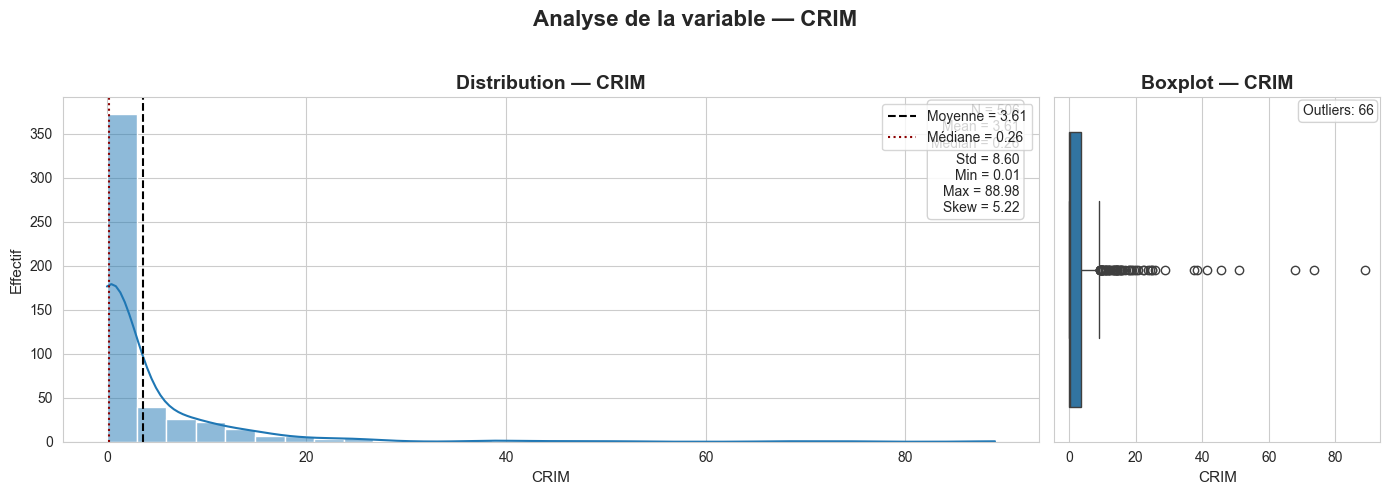

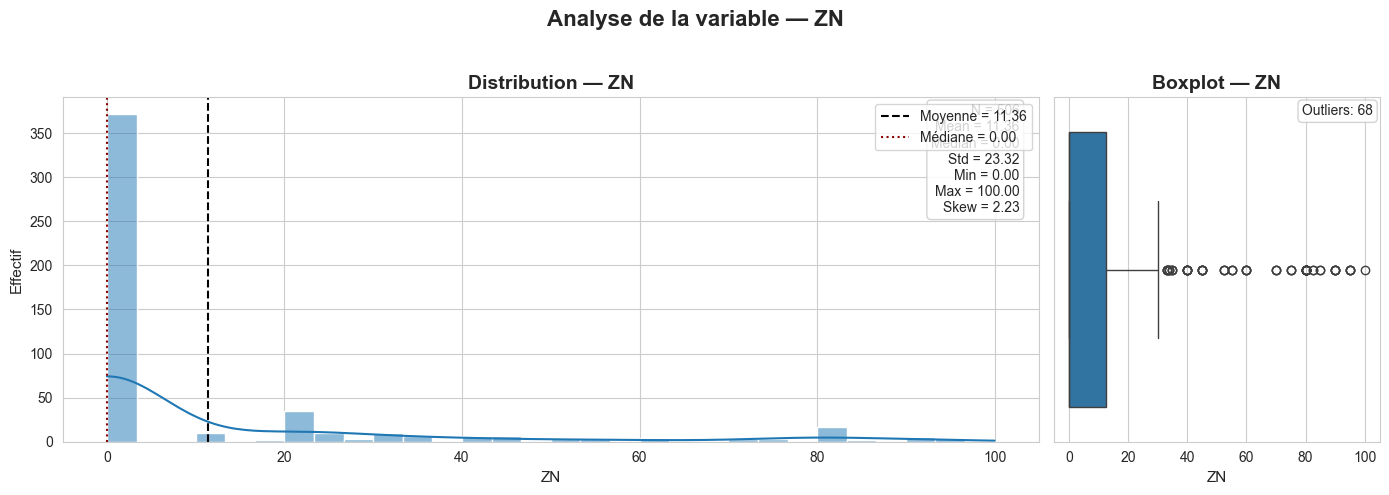

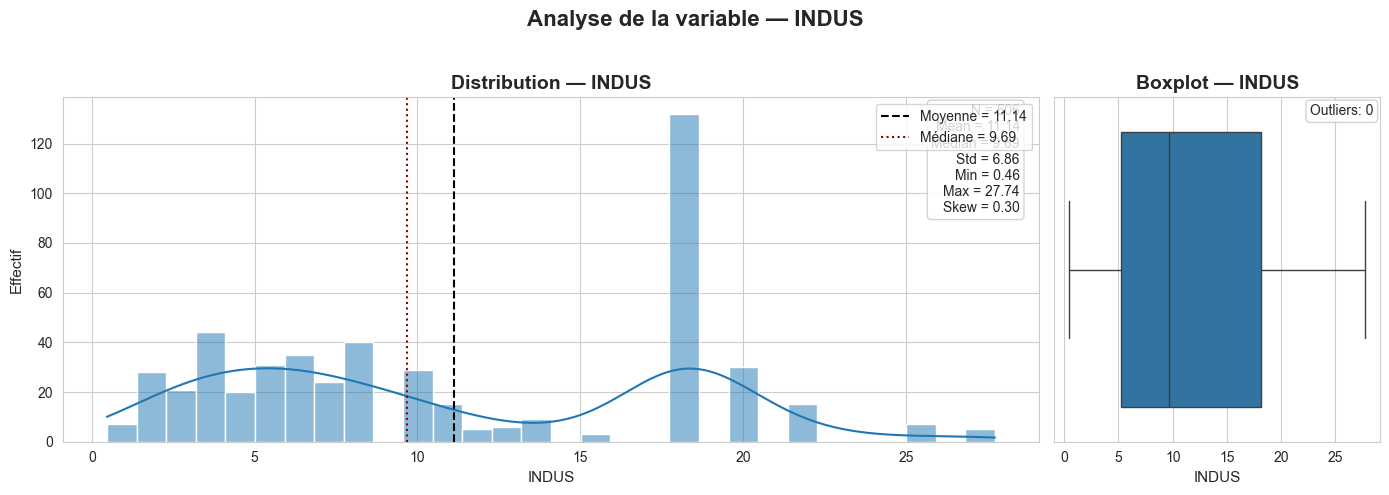

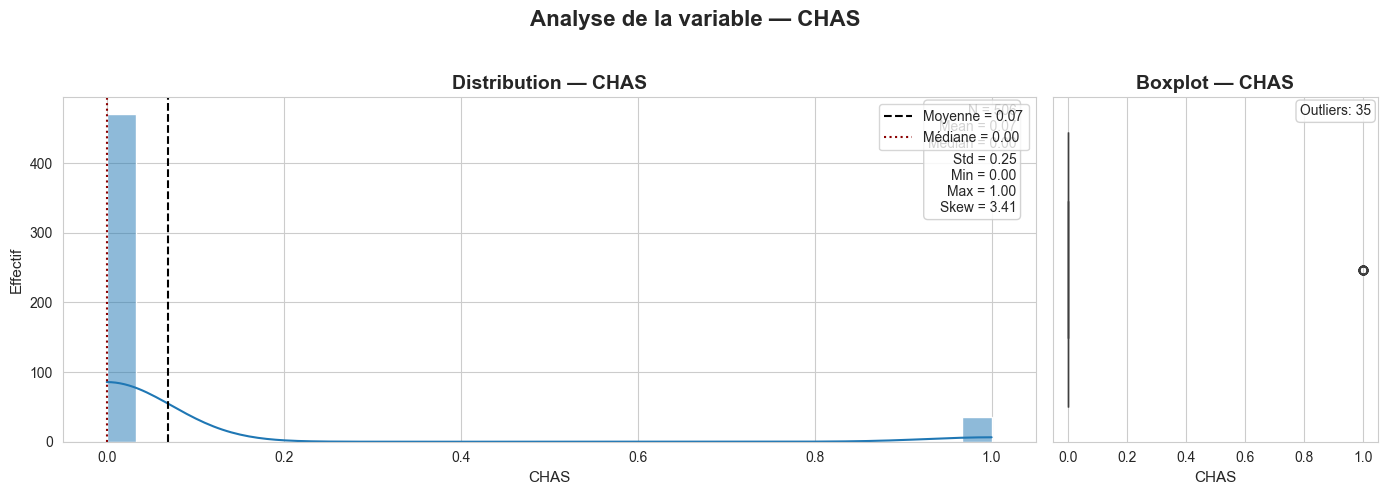

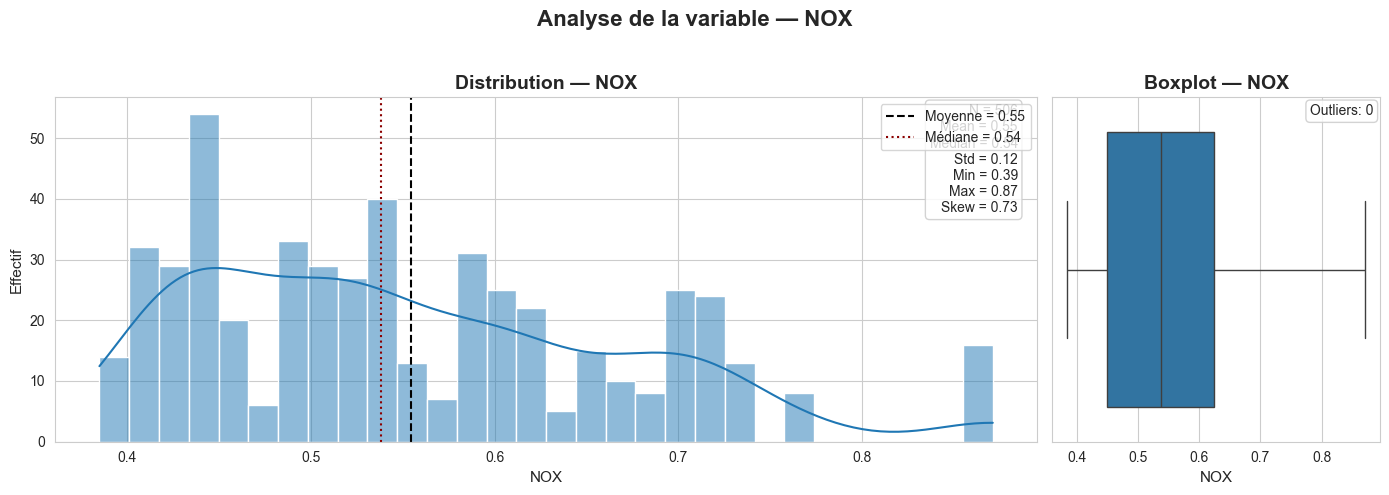

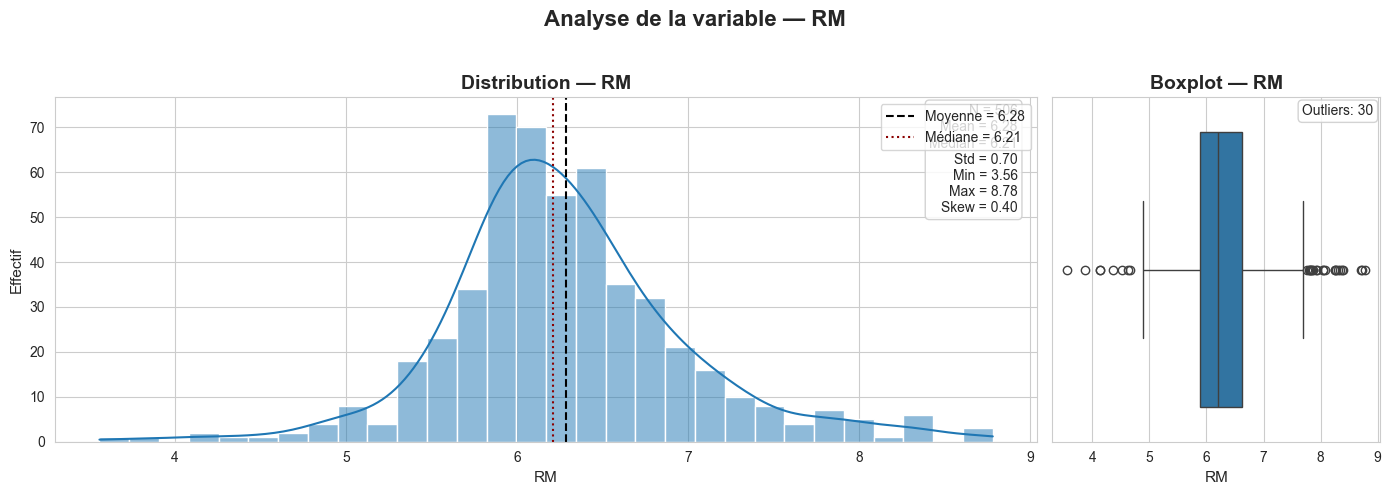

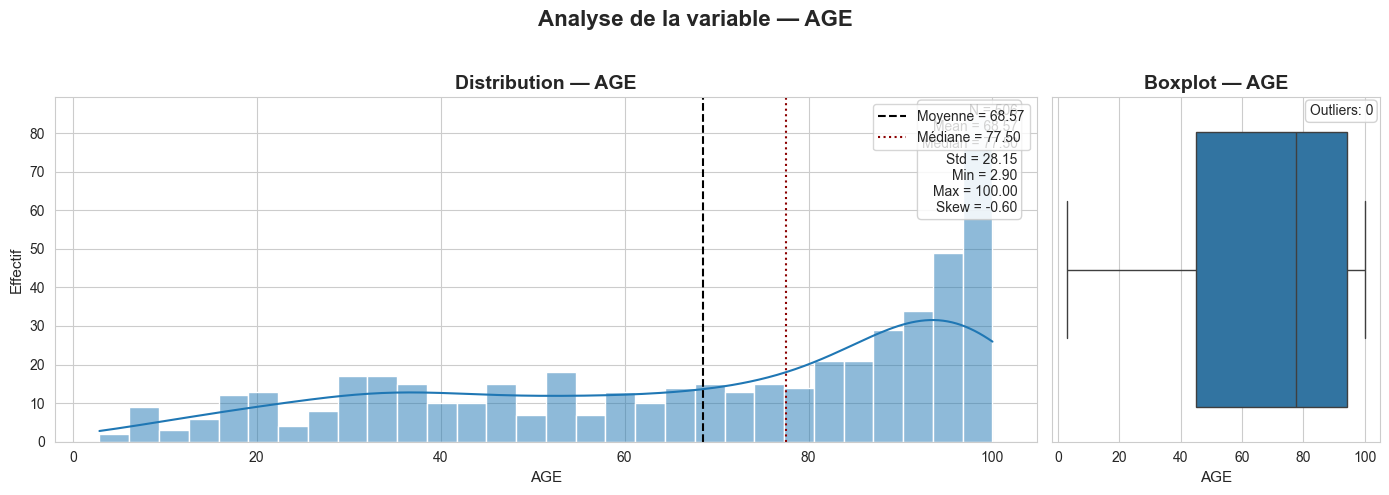

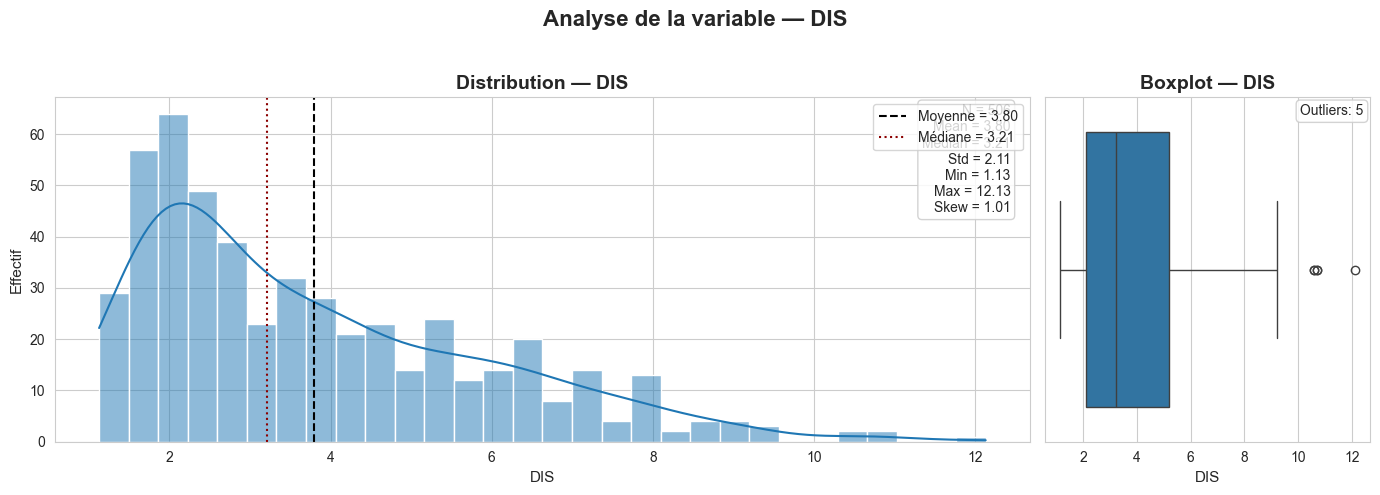

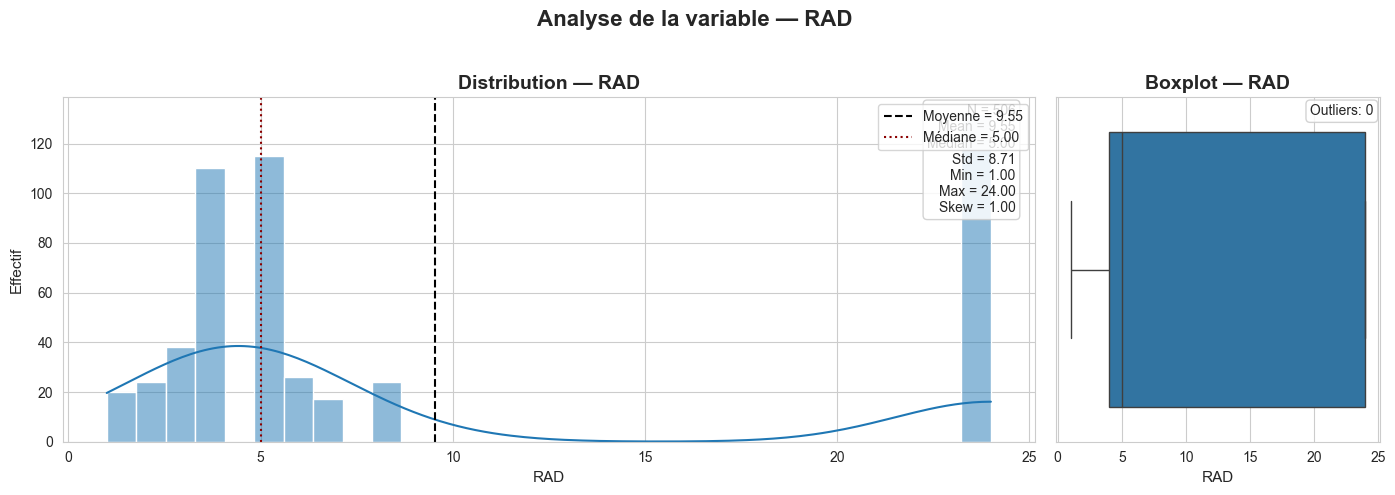

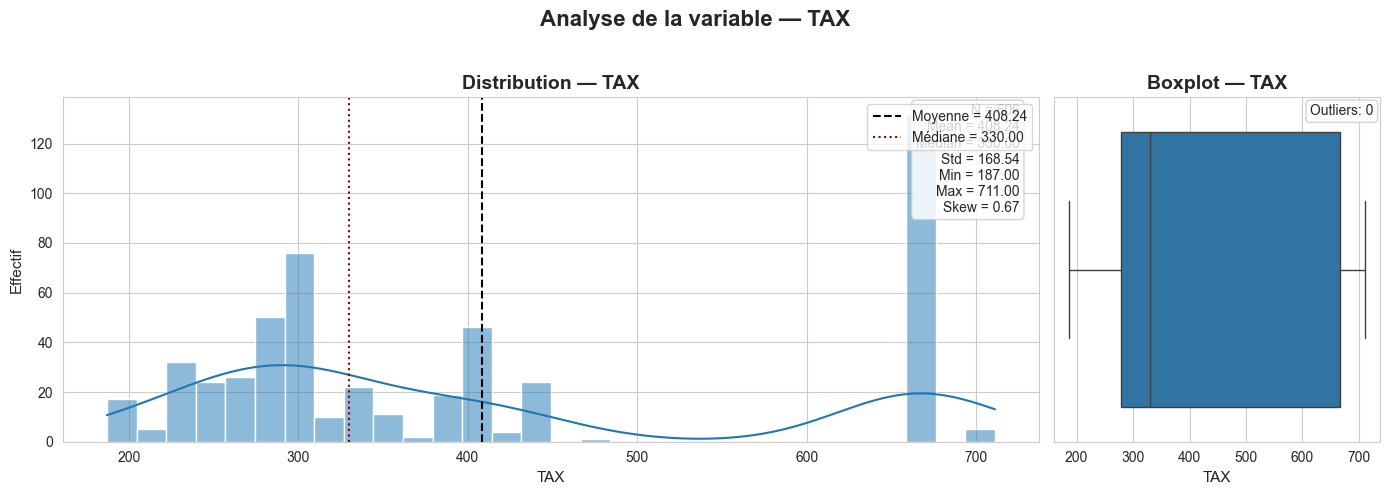

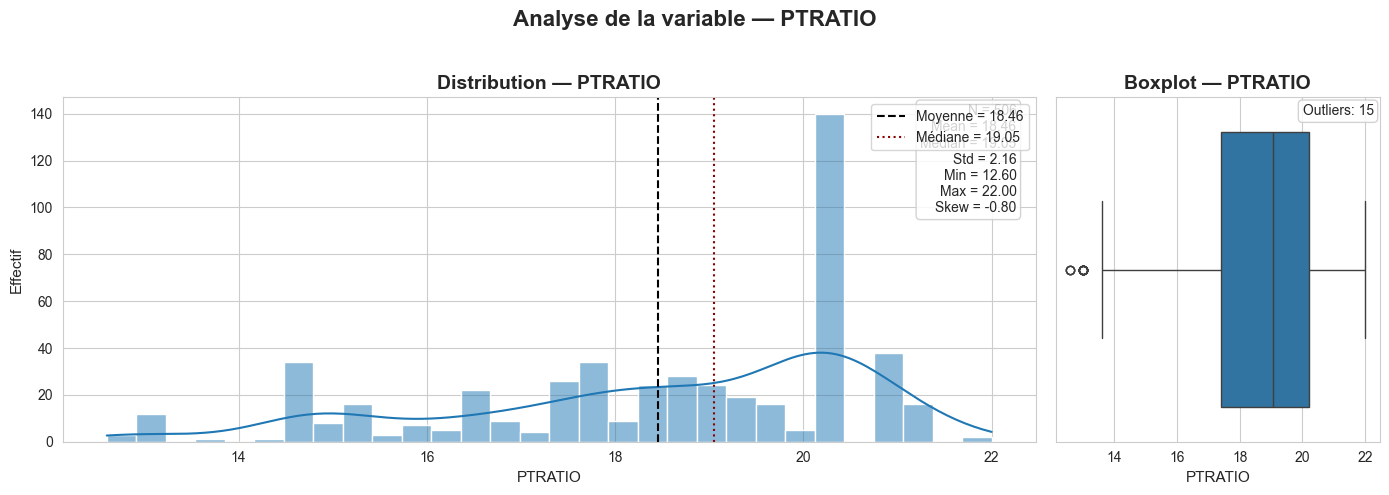

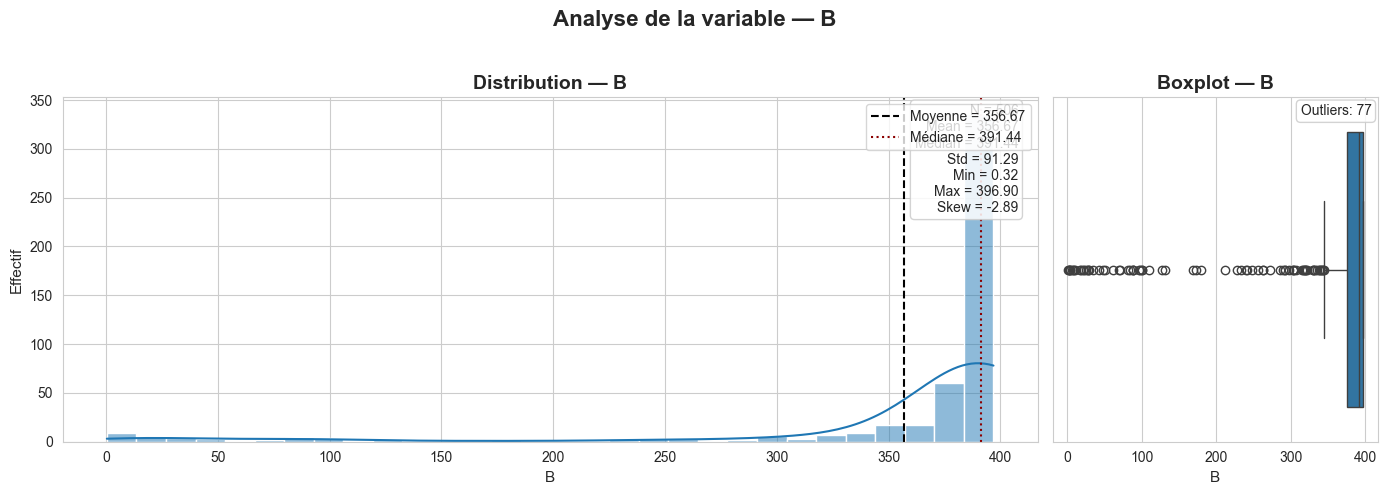

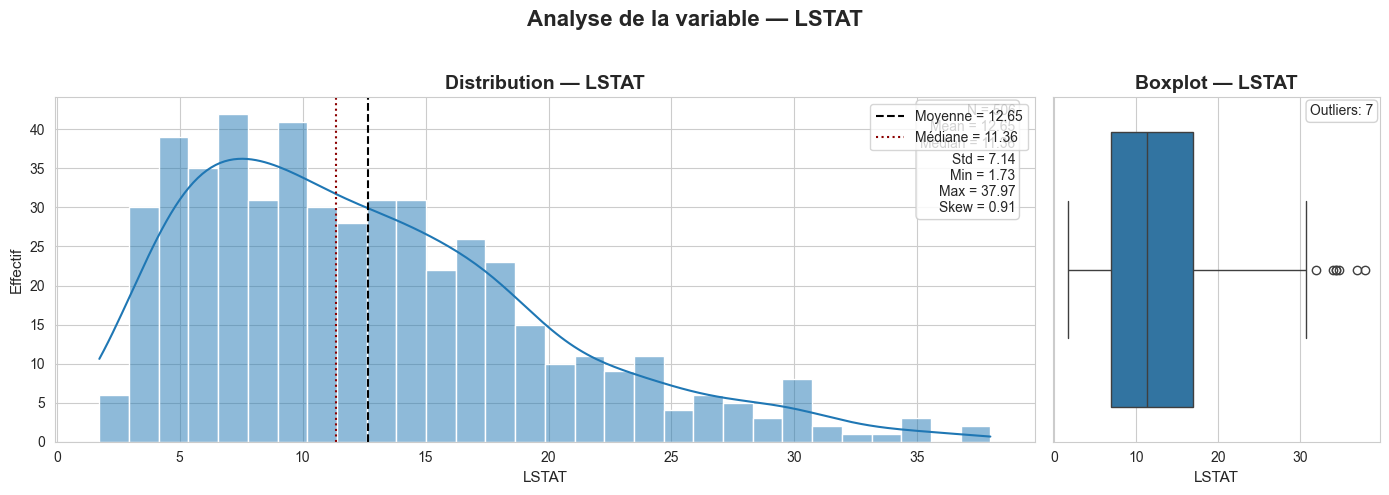

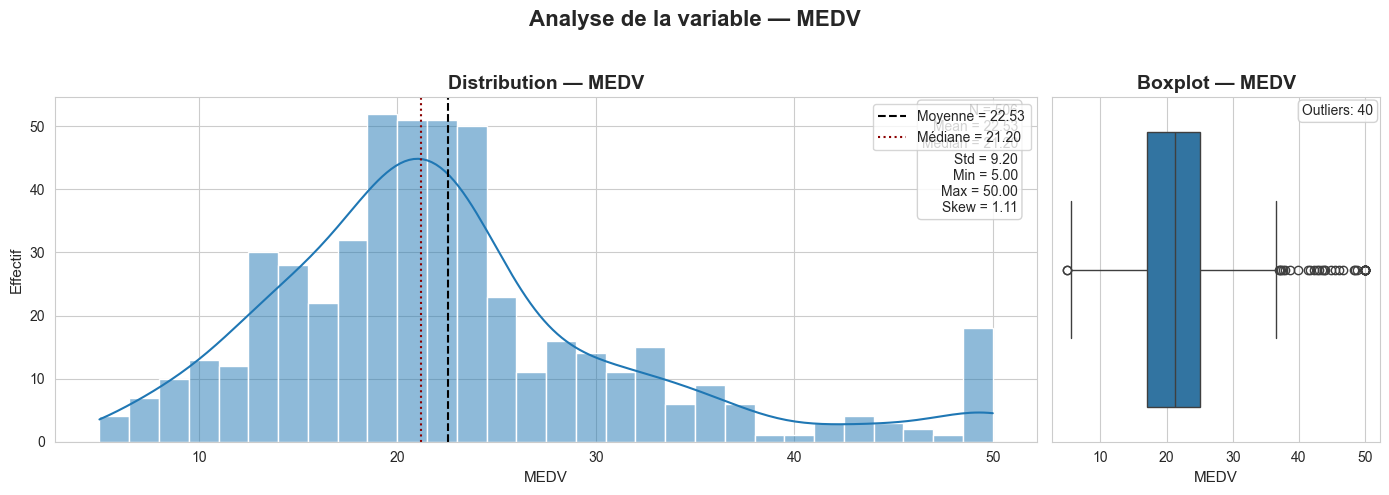

In [14]:
import os
from typing import List, Optional

# --- Configuration visuelle (professionnelle) ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})


def summary_stats(series: pd.Series) -> dict:
    s = series.dropna()
    return {
        "count": int(s.count()),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std()),
        "min": float(s.min()),
        "25%": float(s.quantile(0.25)),
        "50%": float(s.quantile(0.50)),
        "75%": float(s.quantile(0.75)),
        "max": float(s.max()),
        "skew": float(s.skew()),
        "kurtosis": float(s.kurtosis()),
    }

# --- Fonction principale de plotting ---
def plot_distribution_and_box(
    df: pd.DataFrame,
    cols: Optional[List[str]] = None,
    show: bool = True,
    bins: int = 30,
    figsize: tuple = (14, 5)
):
  
   

    # Choisir les colonnes numériques si pas fournies
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in cols:
        s = df[col].dropna()
        if s.empty:
            print(f"[SKIP] {col} : colonne vide")
            continue

        # Eviter colonnes constantes
        if s.nunique() <= 1:
            print(f"[SKIP] {col} : colonne constante ({s.nunique()} unique value)")
            continue

        stats = summary_stats(s)

        # Build figure avec 2 subplots côte-à-côte
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figsize, gridspec_kw={'width_ratios':[3,1]})
        ax_hist, ax_box = axes[0], axes[1]

        # --- Histogramme + KDE ---
        sns.histplot(s, bins=bins, kde=True, ax=ax_hist)
        ax_hist.set_title(f"Distribution — {col}", fontsize=14, fontweight='semibold')
        ax_hist.set_xlabel(col, fontsize=11)
        ax_hist.set_ylabel("Effectif", fontsize=11)

        # Lignes moyenne & médiane
        ax_hist.axvline(stats['mean'], color='black', linestyle='--', linewidth=1.5, label=f"Moyenne = {stats['mean']:.2f}")
        ax_hist.axvline(stats['median'], color='darkred', linestyle=':', linewidth=1.5, label=f"Médiane = {stats['median']:.2f}")
        ax_hist.legend(loc='upper right', frameon=True)

        # Encadré statique (coin supérieur droit)
        stats_text = (
            f"N = {stats['count']}\n"
            f"Mean = {stats['mean']:.2f}\n"
            f"Median = {stats['median']:.2f}\n"
            f"Std = {stats['std']:.2f}\n"
            f"Min = {stats['min']:.2f}\n"
            f"Max = {stats['max']:.2f}\n"
            f"Skew = {stats['skew']:.2f}"
        )
        ax_hist.text(
            0.98, 0.98, stats_text,
            transform=ax_hist.transAxes,
            fontsize=10,
            va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='0.8')
        )

        # --- Boxplot ---
        sns.boxplot(x=s, ax=ax_box, orient='h')
        ax_box.set_title(f"Boxplot — {col}", fontsize=14, fontweight='semibold')
        ax_box.set_xlabel(col, fontsize=11)

        # Calcul des outliers (IQR)
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        outliers = s[(s < Q1 - 1.5 * IQR) | (s > Q3 + 1.5 * IQR)]
        outlier_text = f"Outliers: {outliers.count()}"
        ax_box.text(
            0.98, 0.98, outlier_text,
            transform=ax_box.transAxes,
            fontsize=10,
            va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='0.8')
        )

        # Titre général et layout
        plt.suptitle(f"Analyse de la variable — {col}", fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

       
        plt.show()
        

        


plot_distribution_and_box(data, cols=data.columns, show=True, bins=30)
